In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "NF-YB"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn000781,MEDERRKNEPNVANKGSPESSCSKNNNIVNNNNKEQDRFLPIANVG...,178,1
1,Achn021921,MTKIIKEMLPPDVRVARDAQDLLIECCVEFINLISSESNEVCNKEE...,346,1
2,Achn042271,MVSTGEERGLVVYDGDYFEADHVPHAVSTVLISPVTFNRTAKKSSV...,285,1
3,Achn066231,MADGDPLSPGGGSHESGDQSPRSGVREQDRFLPIANISRIMKKALP...,153,1
4,Achn094371,MAGKKNLNSPIGSPSSDKEQDRFLPIANVSRIMKKSLPANAKISKE...,215,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1469,0.019355,0.0,0.000000,0.019355,0.000000,0.000000,0.000000,0.006452,0.000000,0.006452,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
990,0.006289,0.0,0.006289,0.018868,0.000000,0.000000,0.000000,0.006289,0.000000,0.012579,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
1563,0.000000,0.0,0.005682,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,...,0.0,0.0,0.0,0.000000,0.005682,0.0,0.005682,0.0,0.0,0.000000
615,0.000000,0.0,0.005747,0.000000,0.000000,0.000000,0.011494,0.000000,0.022989,0.005747,...,0.0,0.0,0.0,0.005747,0.000000,0.0,0.000000,0.0,0.0,0.000000
5657,0.033333,0.0,0.014815,0.018519,0.003704,0.003704,0.007407,0.000000,0.000000,0.014815,...,0.0,0.0,0.0,0.003704,0.003704,0.0,0.000000,0.0,0.0,0.007407


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4939, 441)
X_test: (1235, 441)
y_train: (4939,)
y_test: (1235,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 38s 625ms/step - accuracy: 0.5625 - loss: 0.6930

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7628 - loss: 0.6731   

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8221 - loss: 0.5985

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8316 - loss: 0.5770 - val_accuracy: 0.9666 - val_loss: 0.0869


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0436

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0639 

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9820 - loss: 0.0643

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9820 - loss: 0.0642 - val_accuracy: 0.9879 - val_loss: 0.0438


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0736

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0501 

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9825 - loss: 0.0469

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.0464 - val_accuracy: 0.9858 - val_loss: 0.0375


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0392

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0386 

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0361

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0355 - val_accuracy: 0.9848 - val_loss: 0.0513


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0429

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0212 

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0233

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0235 - val_accuracy: 0.9858 - val_loss: 0.0439


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0018

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0232 

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0201

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0196 - val_accuracy: 0.9889 - val_loss: 0.0303


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0041

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0168 

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0157

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0155 - val_accuracy: 0.9889 - val_loss: 0.0345


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0056

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0127 

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0130

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0128 - val_accuracy: 0.9798 - val_loss: 0.0446


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0062

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0167 

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0152

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0151 - val_accuracy: 0.9818 - val_loss: 0.0413


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0120

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0173 

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0141

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0134 - val_accuracy: 0.9879 - val_loss: 0.0373


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0050

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0082 

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0085

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0085 - val_accuracy: 0.9889 - val_loss: 0.0395


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.2381e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0080     

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0078

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0076 - val_accuracy: 0.9818 - val_loss: 0.0545


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0059

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0042 

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0043

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0044 - val_accuracy: 0.9696 - val_loss: 0.1007


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0397

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0127 

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0108

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0102 - val_accuracy: 0.9848 - val_loss: 0.0546


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.1211e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0043     

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0041

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0041 - val_accuracy: 0.9737 - val_loss: 0.0839


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0014

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0139 

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0121

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0119 - val_accuracy: 0.9848 - val_loss: 0.0565



[Train Accuracy: 99.65% - Test Accuracy: 97.89%]


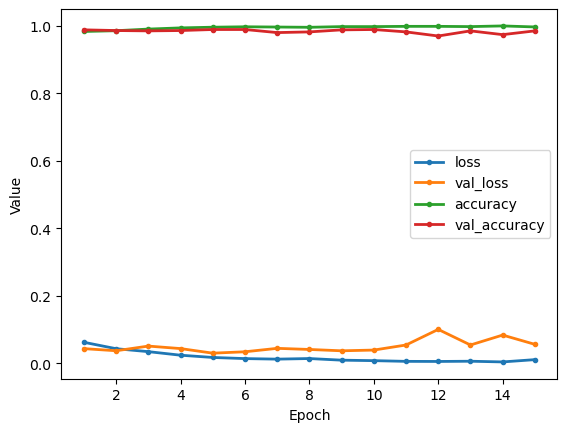

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1469,0.006494,0.0,0.000000,0.006494,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
990,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1563,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
615,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5657,0.000000,0.0,0.007435,0.003717,0.003717,0.0,0.003717,0.0,0.0,0.003717,...,0.0,0.0,0.0,0.003717,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4939, 8798)
X_test: (1235, 8798)
y_train: (4939,)
y_test: (1235,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,252,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,295,809 (8.76 MB)

 Trainable params: 2,295,809 (8.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 39s 643ms/step - accuracy: 0.5312 - loss: 0.6932

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5183 - loss: 0.6930   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5773 - loss: 0.6918

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6180 - loss: 0.6892

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6445 - loss: 0.6848

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6664 - loss: 0.6775

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6854 - loss: 0.6671

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7024 - loss: 0.6541

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7179 - loss: 0.6389

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7319 - loss: 0.6222 - val_accuracy: 0.9949 - val_loss: 0.0643


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0621

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9958 - loss: 0.0538 

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9941 - loss: 0.0509

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9941 - loss: 0.0477

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9939 - loss: 0.0456

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9936 - loss: 0.0441

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9933 - loss: 0.0432

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9931 - loss: 0.0424

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9931 - loss: 0.0416

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9931 - loss: 0.0408

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9931 - loss: 0.0407 - val_accuracy: 0.9960 - val_loss: 0.0059


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9844 - loss: 0.0168

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9947 - loss: 0.0097 

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9956 - loss: 0.0108

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9958 - loss: 0.0109

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9963 - loss: 0.0104

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9966 - loss: 0.0098

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9969 - loss: 0.0093

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0088

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9973 - loss: 0.0084

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9974 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 0.0030


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 9.8532e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0015     

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0017

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0017

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0016

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0015

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0015 

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9999 - loss: 0.0016

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9999 - loss: 0.0016

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9999 - loss: 0.0016

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9970 - val_loss: 0.0042


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.7612e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 4.6462e-04 

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.4297e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.8068e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.9453e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.8811e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.7655e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.6563e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5632e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 5.4680e-04 - val_accuracy: 0.9990 - val_loss: 0.0024


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 3.6181e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 3.3359e-04 

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 3.3862e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2309e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1563e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0517e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9439e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9065e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8882e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8711e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.8675e-04 - val_accuracy: 0.9970 - val_loss: 0.0054


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.2138e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7893e-04 

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3249e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2135e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0523e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9275e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8143e-04

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7288e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6530e-04

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5812e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.5354e-04 - val_accuracy: 0.9970 - val_loss: 0.0032


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 7.0495e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9513e-04 

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8477e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7631e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6982e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6630e-04

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6132e-04

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5636e-04

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5233e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.4934e-04 - val_accuracy: 0.9970 - val_loss: 0.0040


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.7302e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.9014e-04 

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6667e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5435e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4571e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3960e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3503e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3072e-04

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2714e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2361e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.2313e-04 - val_accuracy: 0.9970 - val_loss: 0.0035


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.3887e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6601e-04 

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2750e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9980e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8024e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6513e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5504e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4957e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4850e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.4674e-04 - val_accuracy: 1.0000 - val_loss: 0.0011


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.8431e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.5261e-04 

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3813e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2587e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1717e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0917e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0308e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.9712e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.6532e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.3048e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 9.2112e-05 - val_accuracy: 0.9970 - val_loss: 0.0032


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.4001e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.6929e-05 

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.9820e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5792e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.7316e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.9021e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.9453e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.9107e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.8540e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 5.8119e-05 - val_accuracy: 0.9970 - val_loss: 0.0033


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 8.8930e-06

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9387e-05 

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1187e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3242e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4696e-05

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5619e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6415e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6801e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7228e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7571e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.7744e-05 - val_accuracy: 0.9990 - val_loss: 0.0027



[Train Accuracy: 100.00% - Test Accuracy: 99.43%]


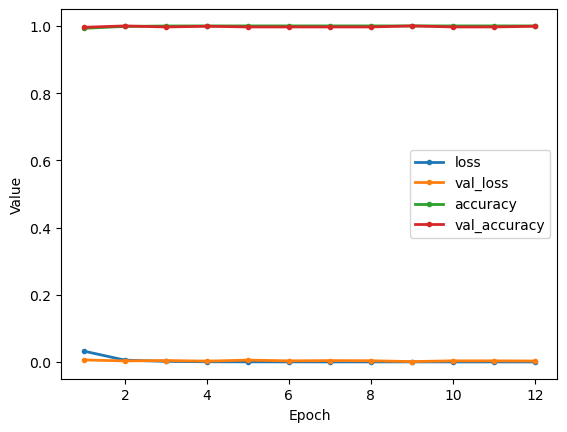

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

26/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYW,YYYX,YYYY
1469,0.0,0.0,0.0,0.006536,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
990,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1563,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5657,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,654,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,696,065 (139.98 MB)

 Trainable params: 36,696,065 (139.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 52s 863ms/step - accuracy: 0.5312 - loss: 0.6931

 2/62 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.5430 - loss: 0.6931 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.5582 - loss: 0.6930

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5778 - loss: 0.6929

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5922 - loss: 0.6928

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.6020 - loss: 0.6926

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.6060 - loss: 0.6925

 8/62 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6122 - loss: 0.6923

 9/62 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6200 - loss: 0.6921

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6286 - loss: 0.6919

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.6380 - loss: 0.6916

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.6474 - loss: 0.6913

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.6568 - loss: 0.6910

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.6655 - loss: 0.6906

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.6738 - loss: 0.6902

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.6817 - loss: 0.6898

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.6887 - loss: 0.6893

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.6954 - loss: 0.6888

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.7018 - loss: 0.6882

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.7080 - loss: 0.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.7139 - loss: 0.6868

22/62 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.7195 - loss: 0.6861

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.7249 - loss: 0.6853

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7300 - loss: 0.6844

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7349 - loss: 0.6835

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7395 - loss: 0.6825

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7438 - loss: 0.6815

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7480 - loss: 0.6804

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7520 - loss: 0.6792

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7558 - loss: 0.6780

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7596 - loss: 0.6766

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7631 - loss: 0.6752

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7666 - loss: 0.6737

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7699 - loss: 0.6722

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7731 - loss: 0.6705

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7761 - loss: 0.6688

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7790 - loss: 0.6670

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7818 - loss: 0.6651

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7846 - loss: 0.6631

40/62 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.7872 - loss: 0.6610

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.7898 - loss: 0.6589

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.7922 - loss: 0.6566

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.7947 - loss: 0.6543

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.7970 - loss: 0.6519

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.7993 - loss: 0.6495

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8015 - loss: 0.6469

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.8036 - loss: 0.6443

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8057 - loss: 0.6417

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8078 - loss: 0.6390

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8098 - loss: 0.6363

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8117 - loss: 0.6335

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8135 - loss: 0.6307

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8153 - loss: 0.6279

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8171 - loss: 0.6251

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8188 - loss: 0.6222

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8205 - loss: 0.6193

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8222 - loss: 0.6164

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8238 - loss: 0.6135

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8254 - loss: 0.6106

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8269 - loss: 0.6077

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8284 - loss: 0.6047

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8299 - loss: 0.6018

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.8314 - loss: 0.5990 - val_accuracy: 0.9747 - val_loss: 0.0606


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9688 - loss: 0.0817

 2/62 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9727 - loss: 0.0716 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9731 - loss: 0.0684

 4/62 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9749 - loss: 0.0636

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.9768 - loss: 0.0595

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.9785 - loss: 0.0559

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9800 - loss: 0.0527

 8/62 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9813 - loss: 0.0500

 9/62 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9822 - loss: 0.0481

10/62 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9830 - loss: 0.0463

11/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.9838 - loss: 0.0447

12/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.9845 - loss: 0.0432

13/62 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9850 - loss: 0.0420

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9856 - loss: 0.0409

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9860 - loss: 0.0398

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9865 - loss: 0.0389

17/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9868 - loss: 0.0381

18/62 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9872 - loss: 0.0373

19/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9875 - loss: 0.0366

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9878 - loss: 0.0360

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9881 - loss: 0.0354

22/62 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9884 - loss: 0.0348

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9886 - loss: 0.0342

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9889 - loss: 0.0337

25/62 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9891 - loss: 0.0333

26/62 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9893 - loss: 0.0328

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9895 - loss: 0.0323

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9897 - loss: 0.0319

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9899 - loss: 0.0315

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9901 - loss: 0.0311

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9902 - loss: 0.0308

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9904 - loss: 0.0304

33/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9905 - loss: 0.0302

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9906 - loss: 0.0299

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9908 - loss: 0.0297

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9909 - loss: 0.0294

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9910 - loss: 0.0292

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9911 - loss: 0.0289

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9912 - loss: 0.0287

40/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9913 - loss: 0.0285

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9914 - loss: 0.0283

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9915 - loss: 0.0281

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9916 - loss: 0.0279

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9917 - loss: 0.0277

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9918 - loss: 0.0275

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9919 - loss: 0.0272

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9920 - loss: 0.0271

48/62 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9920 - loss: 0.0269

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9921 - loss: 0.0267

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9922 - loss: 0.0265

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9922 - loss: 0.0264

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9923 - loss: 0.0262

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9924 - loss: 0.0260

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9924 - loss: 0.0259

55/62 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9925 - loss: 0.0257

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9926 - loss: 0.0256

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9926 - loss: 0.0254

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9927 - loss: 0.0252

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9927 - loss: 0.0251

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9928 - loss: 0.0249

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9928 - loss: 0.0248

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9929 - loss: 0.0247

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9929 - loss: 0.0245 - val_accuracy: 0.9949 - val_loss: 0.0110


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 1.0000 - loss: 0.0019

 2/62 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 0.0018 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 0.0018

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 0.0019

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 0.0019

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 0.0020

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 0.0020

 8/62 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 0.0020

 9/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 0.0021

10/62 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 0.0021

11/62 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 0.0021

12/62 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 0.0021

13/62 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 0.0021

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 0.0021

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 0.0021

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 0.0020

17/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 0.0020

18/62 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 0.0020

19/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 0.0020

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 0.0020

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 0.0020

22/62 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 0.0020

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 0.0020

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 0.0020

25/62 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 0.0020

26/62 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 0.0020

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 0.0020

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0020

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 0.0020

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0019

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0019

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0019

33/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0019

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 0.0019

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 0.0019

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 0.0019

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 0.0019

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 0.0019

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 0.0019

40/62 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0019

41/62 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 0.0019

42/62 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 0.0019

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 0.0019

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 1.0000 - loss: 0.0019

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 1.0000 - loss: 0.0019

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 1.0000 - loss: 0.0018

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 1.0000 - loss: 0.0018

48/62 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 1.0000 - loss: 0.0018

49/62 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 1.0000 - loss: 0.0018

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 0.0018

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 0.0018

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 0.0018

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 1.0000 - loss: 0.0018

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 1.0000 - loss: 0.0018

55/62 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 1.0000 - loss: 0.0018

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 0.0018

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 0.0018

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 0.0018

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 0.0018

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 0.0018

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 0.0018

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 0.0018

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9939 - val_loss: 0.0109


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 1.0000 - loss: 9.3529e-04

 2/62 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 9.1558e-04 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 0.0012    

 4/62 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 0.0012

 5/62 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 0.0013

 6/62 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0013

 7/62 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0013

 8/62 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 1.0000 - loss: 0.0012

 9/62 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 1.0000 - loss: 0.0012

10/62 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 1.0000 - loss: 0.0012

11/62 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 1.0000 - loss: 0.0012

12/62 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 1.0000 - loss: 0.0012

13/62 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 1.0000 - loss: 0.0011

14/62 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 1.0000 - loss: 0.0011

15/62 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 0.0011

16/62 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 0.0011

17/62 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 1.0000 - loss: 0.0011

18/62 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 0.0011

19/62 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 0.0011

20/62 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 0.0011

21/62 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 0.0010

22/62 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 0.0010

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 0.0010

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 1.0000 - loss: 0.0010

25/62 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 1.0000 - loss: 0.0010

26/62 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 1.0000 - loss: 0.0010

27/62 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 9.9413e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 9.8578e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 9.7753e-04

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 9.6932e-04

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 9.6126e-04

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 9.5334e-04

33/62 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 9.4554e-04

34/62 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 9.4139e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 9.3706e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 9.3257e-04

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 9.2794e-04

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 9.2327e-04

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 9.1861e-04

40/62 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 9.1402e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 9.0939e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 9.0471e-04

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 9.0012e-04

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 8.9556e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 8.9109e-04

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 8.8662e-04

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 8.8225e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 8.7788e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 8.7353e-04

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 8.6918e-04

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 8.6491e-04

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 8.6064e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 8.5644e-04

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 8.5224e-04

55/62 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 8.4813e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 8.4407e-04

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 8.4010e-04

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 8.3618e-04

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 8.3225e-04

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 8.2929e-04

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 8.2638e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 8.2349e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 1.0000 - loss: 8.2068e-04 - val_accuracy: 0.9929 - val_loss: 0.0151


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 1.0000 - loss: 2.6982e-04

 2/62 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 2.8087e-04 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.7733e-04

 4/62 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 2.7628e-04

 5/62 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.7566e-04

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.7214e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.7029e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.6832e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.6851e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.6884e-04

11/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.6915e-04

12/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.6863e-04

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 2.6757e-04

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 2.6616e-04

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.6486e-04

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.6399e-04

17/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 2.6305e-04

18/62 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.6179e-04

19/62 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.6069e-04

20/62 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.6041e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 2.6013e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 2.5978e-04

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.5922e-04

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.5887e-04

25/62 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.5869e-04

26/62 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.5943e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 2.6004e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 2.6066e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.6202e-04

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.6343e-04

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.6466e-04

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.6571e-04

33/62 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.6686e-04

34/62 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.6785e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.6874e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.6945e-04

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.7010e-04

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.7071e-04

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.7130e-04

40/62 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.7176e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.7211e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.7235e-04

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.7253e-04

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.7265e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.7273e-04

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.7276e-04

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.7280e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.7280e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.7274e-04

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.7264e-04

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.7252e-04

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.7239e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.7220e-04

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.7198e-04

55/62 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.7173e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.7146e-04

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.7119e-04

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.7093e-04

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.7069e-04

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.7042e-04

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.7013e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.6983e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 2.6953e-04 - val_accuracy: 0.9929 - val_loss: 0.0202


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 1.0000 - loss: 4.8050e-04

 2/62 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 4.5113e-04 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 4.2520e-04

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 3.9320e-04

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 3.7291e-04

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 3.5464e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 3.3875e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 3.2487e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 3.1584e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 3.0716e-04

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 2.9958e-04

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.9312e-04

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.9087e-04

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.8886e-04

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.8647e-04

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.8489e-04

17/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.8417e-04

18/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.8295e-04

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.8154e-04

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.7990e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.7827e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.7645e-04

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.7444e-04

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 2.7242e-04

25/62 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.7050e-04

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 2.6853e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 2.6669e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.6480e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 2.6288e-04

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.6103e-04

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.5931e-04

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 2.5802e-04

33/62 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 2.5671e-04

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.5540e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.5410e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.5276e-04

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.5138e-04

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.5000e-04

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.4869e-04

40/62 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.4739e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4610e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4491e-04

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4373e-04

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4257e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4143e-04

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4031e-04

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.3919e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.3808e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.3696e-04

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.3588e-04

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.3479e-04

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.3378e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.3276e-04

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.3174e-04

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.3074e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.2976e-04

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.2880e-04

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.2785e-04

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.2690e-04

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.2596e-04

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.2502e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 2.2410e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.2320e-04 - val_accuracy: 0.9929 - val_loss: 0.0197


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 1.0000 - loss: 8.4095e-05

 2/62 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 1.0399e-04 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 1.0368e-04

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.0901e-04

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.6294e-04

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.9234e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.0911e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 2.1793e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 2.3198e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 2.4908e-04

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.6040e-04

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.6873e-04

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.7398e-04

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.7693e-04

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.7867e-04

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.7927e-04

17/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.8050e-04

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.8080e-04

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.8104e-04

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.8081e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.8017e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.7917e-04

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.7797e-04

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.7662e-04

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.7510e-04

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.7351e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.7191e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.7024e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.6854e-04

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.6831e-04

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.6791e-04

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.6749e-04

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.6692e-04

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.6624e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.6547e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.6464e-04

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.6376e-04

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.6281e-04

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.6179e-04

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.6076e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.5970e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.5862e-04

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.5752e-04

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.5641e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.5528e-04

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.5415e-04

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.5303e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.5192e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.5084e-04

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.4977e-04

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.4873e-04

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.4770e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.4669e-04

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.4568e-04

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.4467e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.4374e-04

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.4282e-04

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.4190e-04

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.4100e-04

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.4010e-04

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.3919e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.3830e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 2.3744e-04 - val_accuracy: 0.9929 - val_loss: 0.0150


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 1.0000 - loss: 1.8559e-04

 2/62 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 1.7787e-04 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.6502e-04

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.5476e-04

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.4688e-04

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.4088e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.3588e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.3132e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.2774e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.2435e-04

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.2104e-04

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.1803e-04

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.1545e-04

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.1354e-04

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.1275e-04

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.1177e-04

17/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.1082e-04

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.0986e-04

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.0904e-04

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.0819e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.0732e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.0648e-04

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.0590e-04

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.0528e-04

25/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.0465e-04

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.0403e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.0343e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.0283e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.0222e-04

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.0164e-04

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.0109e-04

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.0055e-04

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.0003e-04

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 9.9534e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 9.9039e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 9.8559e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 9.8110e-05

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 9.7649e-05

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 9.7209e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 9.6889e-05

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 9.6590e-05

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 9.6287e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 9.5985e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 9.5720e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 9.5463e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 9.5197e-05

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 9.4918e-05

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 9.4651e-05

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 9.4371e-05

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 9.4111e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 9.3846e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 9.3616e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 9.3382e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 9.3144e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.2921e-05

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.2700e-05

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.2479e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.2275e-05

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.2069e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.1863e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 9.1657e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 9.1450e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 9.1250e-05 - val_accuracy: 0.9929 - val_loss: 0.0209


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 1.0000 - loss: 6.2499e-05

 2/62 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.7769e-05 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 5.9942e-05

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 6.0116e-05

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 6.0213e-05

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 6.0472e-05

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 6.0336e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 6.0055e-05

 9/62 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 5.9930e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 5.9586e-05

11/62 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 5.9533e-05

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 5.9295e-05

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 5.8985e-05

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 5.8743e-05

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.8460e-05

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.8382e-05

17/62 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 5.8227e-05

18/62 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.8103e-05

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.7935e-05

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 5.7809e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 5.7659e-05

22/62 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.7477e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 5.7282e-05

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 5.7143e-05

25/62 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 5.6984e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.6826e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.6729e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.6607e-05

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.6455e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.6281e-05

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.6141e-05

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.5985e-05

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.5817e-05

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.5636e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.5462e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 5.5280e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.5099e-05

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.4913e-05

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.4724e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.4531e-05

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 5.4418e-05

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 5.4295e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 5.4192e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 5.4084e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 5.4001e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 5.3915e-05

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 5.3830e-05

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 5.3745e-05

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 5.3657e-05

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.3564e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.3483e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.3413e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 5.3344e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 5.3271e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.3192e-05

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 5.3108e-05

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 5.3019e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 5.2929e-05

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 5.2836e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 5.2746e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.2658e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.2568e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 5.2481e-05 - val_accuracy: 0.9919 - val_loss: 0.0224


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 1.0000 - loss: 2.9041e-04

 2/62 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 2.2392e-04 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 1.8938e-04

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.6673e-04

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.5044e-04

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.3785e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.2795e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.2035e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.1397e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 1.0872e-04

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.0409e-04

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 1.0029e-04

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 9.7062e-05

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 9.4224e-05

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 9.1852e-05

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 8.9637e-05

17/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 8.7631e-05

18/62 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 8.5810e-05

19/62 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.4128e-05

20/62 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.2546e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 8.1212e-05

22/62 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 1.0000 - loss: 8.0032e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 1.0000 - loss: 7.8894e-05

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 1.0000 - loss: 7.7872e-05

25/62 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 1.0000 - loss: 7.7277e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 7.6668e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 7.6057e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 1.0000 - loss: 7.5511e-05

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.4985e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.4508e-05

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.4017e-05

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.3544e-05

33/62 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.3078e-05

34/62 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 7.2612e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 7.2197e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 7.1860e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 7.1521e-05

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 7.1196e-05

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 7.0940e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.0678e-05

41/62 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.0442e-05

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 7.0193e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.9946e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.9698e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 6.9455e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 6.9205e-05

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 6.8956e-05

48/62 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 6.8710e-05

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.8474e-05

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 6.8235e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 6.7989e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 6.7755e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 6.7531e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.7409e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.7301e-05

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.7187e-05

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.7064e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.6935e-05

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.6822e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.6700e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 6.6576e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 6.6452e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 1.0000 - loss: 6.6332e-05 - val_accuracy: 0.9929 - val_loss: 0.0203


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 1.0000 - loss: 2.9254e-05

 2/62 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 2.9301e-05

 3/62 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.9194e-05

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 2.8409e-05

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.8087e-05

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.9207e-05

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 3.1818e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.3355e-05

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.4577e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.5351e-05

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.5875e-05

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.6322e-05

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.6791e-05

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.7144e-05

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.7352e-05

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.7440e-05

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.7623e-05

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.7700e-05

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.7861e-05

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.8022e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.8152e-05

22/62 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.8249e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.8294e-05

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.8303e-05

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 3.8297e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 3.8264e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 3.8221e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 3.8181e-05

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 3.8207e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 3.8225e-05

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 3.8222e-05

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 3.8214e-05

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.8185e-05

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.8230e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.8256e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.8266e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.8271e-05

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.8279e-05

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 3.8282e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.8282e-05

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.8270e-05

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.8255e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.8239e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.8234e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.8219e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.8204e-05

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 3.8184e-05

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.8155e-05

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.8129e-05

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.8108e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.8090e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.8082e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.8069e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.8055e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.8054e-05

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.8059e-05

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.8064e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.8074e-05

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.8089e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.8096e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.8098e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.8101e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 3.8103e-05 - val_accuracy: 0.9929 - val_loss: 0.0215


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 1.0000 - loss: 1.5902e-05

 2/62 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 1.6163e-05 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.5575e-05

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 1.5201e-05

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.5566e-05

 6/62 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.5884e-05

 7/62 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.6354e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.6866e-05

 9/62 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.7160e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.7558e-05

11/62 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 1.8046e-05

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.8721e-05

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.9418e-05

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.9956e-05

15/62 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.0482e-05

16/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.0921e-05

17/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.1319e-05

18/62 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.1689e-05

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.1991e-05

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.2302e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.2544e-05

22/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.2751e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.2919e-05

24/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.3068e-05

25/62 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.3203e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.3327e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.3458e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.3562e-05

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.3716e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.3847e-05

31/62 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.3964e-05

32/62 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.4063e-05

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.4161e-05

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.4249e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.4331e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.4395e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.4451e-05

38/62 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.4495e-05

39/62 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.4537e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.4569e-05

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.4592e-05

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.4625e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.4656e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.4682e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.4711e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 2.4737e-05

47/62 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 2.4757e-05

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.4806e-05

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.4855e-05

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.4908e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 2.4961e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.5006e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.5056e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.5100e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 2.5144e-05

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 2.5181e-05

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 2.5210e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 2.5235e-05

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 2.5256e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 2.5273e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 2.5290e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.5306e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.5322e-05 - val_accuracy: 0.9919 - val_loss: 0.0233



[Train Accuracy: 100.00% - Test Accuracy: 98.54%]


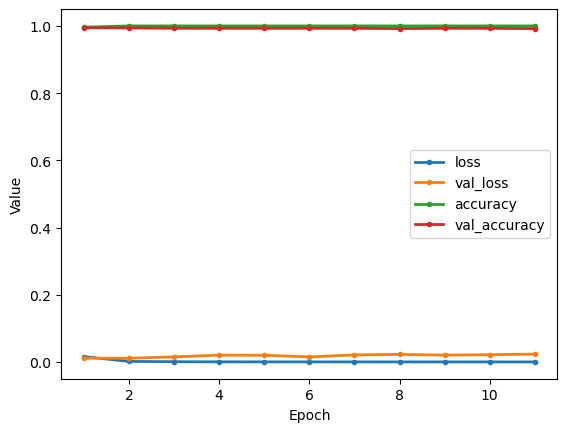

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

 5/39 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

10/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

14/39 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

19/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

24/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

29/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

34/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

 5/39 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

10/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

14/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

19/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

24/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

29/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

34/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [26]:
report.save()

Report saved as Output/Reports/NF-YB/report_L0UF6JR8.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################